# Lending Club Case Study
1. The Lending Club Case Study involves a Consumer Finance Company which specializes in lending various types of loans to urban customers.
2. AIM: To identify risky loan applicants to avoid loan allotment to such applicants to reduce amount of Credit Loss.
3. Identifying driving factors behind loan defaults i.e. driver variables which are strong indicators of 'deafult'

In [145]:
# Import all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import plotly.express as px                 #visualisation
import warnings
%matplotlib inline     
sns.set(color_codes=True)
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 500)

In [146]:
# Function to get information about dataset provided
def get_dataset_info(name_of_dataset: str, df: pd.DataFrame, show_details=False):
    
    # Information about Data Set
    print(f"\n {name_of_dataset} Information: \n-------------------------")

    # Number of Columns and Rows
    print(f"Columns: {df.shape[1]} \nRows: {df.shape[0]}")
    
    if show_details:
        print(f"\n\n{df.dtypes}\n")

### Reading Loan Dataset file
Data Set file contains complete loan data for all loans issued through the time period 2007 t0 2011.

In [147]:
# Read Data Set file 
loan_df = pd.read_csv("loan.csv")

### Get the overview of the Data Set

In [148]:
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [149]:
# Information about Loan Data Set
get_dataset_info(name_of_dataset="Loan Dataset", df=loan_df, show_details=False)


 Loan Dataset Information: 
-------------------------
Columns: 111 
Rows: 39717


In [150]:
loan_df.isnull().sum().sort_values(ascending=False)

verification_status_joint         39717
annual_inc_joint                  39717
mo_sin_old_rev_tl_op              39717
mo_sin_old_il_acct                39717
bc_util                           39717
bc_open_to_buy                    39717
avg_cur_bal                       39717
acc_open_past_24mths              39717
inq_last_12m                      39717
total_cu_tl                       39717
inq_fi                            39717
total_rev_hi_lim                  39717
all_util                          39717
max_bal_bc                        39717
open_rv_24m                       39717
open_rv_12m                       39717
il_util                           39717
total_bal_il                      39717
mths_since_rcnt_il                39717
open_il_24m                       39717
open_il_12m                       39717
open_il_6m                        39717
open_acc_6m                       39717
tot_cur_bal                       39717
tot_coll_amt                      39717


## 1. Data Cleaning
<span style='background:Gainsboro'>Data Cleaning is the process to resolves various data quality issues from the source to get useful data for Analysis. We are using the following Data cleaning techniques to clean up the Loan Dataset. </span>

#### 1.1 Fixing Rows and Columns
- <font color="blue">Delete unnecessary columns - Based of the above dataset there are many Columns having only `null values` so dropping them</font>
- <font color="blue">Rename columns consistently - Renaming Column names like issue_d as issue_date, last_credit_pull_d= last_credit_pull_date</font>
- <font color="lightgrey">Delete incorrect rows, Delete Summary Rows, Delete Extra Rows - Not Found
</font>
- <font color="lightgrey">Add column names if missing, Split columns for more Data, Merge columns for identifiers, Align misaligned columns -> not required </font>

In [151]:
# Dropping columns having only null values
loan_df.dropna(how='all', axis=1, inplace=True)

In [152]:
# Rename column names
loan_df.rename(columns={'issue_d': 'issue_date',
                        'last_credit_pull_d': 'last_credit_pull_date',
                        'last_pymnt_d': 'last_pymnt_date'}, inplace=True)

- <font color="blue">Checking the percentage of missing values in each column with more than threshold of 0 percentage</font> <font color="lightgrey">(for visibility)</font>

In [153]:
column_empty_stat = (loan_df.isnull().mean() * 100).round(2)
column_empty_stat[column_empty_stat > 0]

emp_title                      6.19
emp_length                     2.71
desc                          32.58
title                          0.03
mths_since_last_delinq        64.66
mths_since_last_record        92.99
revol_util                     0.13
last_pymnt_date                0.18
next_pymnt_d                  97.13
last_credit_pull_date          0.01
collections_12_mths_ex_med     0.14
chargeoff_within_12_mths       0.14
pub_rec_bankruptcies           1.75
tax_liens                      0.10
dtype: float64

- <font color="blue">Dropping Columns with more than 40% of NULL Values based on Empty Column Value Stats</font>

In [154]:
# Getting column names which are having empty value more than 40%
drop_missing_value_columns = loan_df.columns[column_empty_stat > 40]

loan_df.drop(columns=drop_missing_value_columns, axis=1, inplace=True)

#### 1.2 Standardize Values
Standardizing Columns as stated below:
- <font color="blue">Column `zip_code` sould be standardised by considering only first three characters</font>
- <font color="blue">Columns `int_rate`, `revol_util` should be standardised by removing percentage suffix. Invalid values should be fixed by converting from String to Float</font>
- <font color="blue">Column `verification_status` have values `Verified and Source Verified` which are same, so replace `Source Verified` with `Verified`</font>
- <font color="blue">Columns `grade`, `sub_grade`, `home_ownership`, `verification_status`, `purpose` and `addr_state` should be standardised by converting to datatype category</font>

In [155]:
# standardised zip_code by considering only first 3 numbers
loan_df.zip_code = loan_df.zip_code.apply(lambda x: str(x)[0:3]).astype('string')

In [156]:
loan_df.int_rate = loan_df.int_rate.apply(lambda x: str(x).replace("%", "").strip()).astype("float64")
loan_df.revol_util = loan_df.revol_util.apply(lambda x: str(x).replace("%", "")).astype("float64")

In [157]:
loan_df.verification_status = loan_df.verification_status.apply(lambda x: str(x).replace("Source Verified", "Verified"))

In [158]:
# Converting Columns to type category
loan_df.grade=loan_df.grade.astype('category')
loan_df.sub_grade=loan_df.sub_grade.astype('category')
loan_df.home_ownership=loan_df.home_ownership.astype('category')
loan_df.verification_status=loan_df.verification_status.astype('category')
loan_df.purpose=loan_df.purpose.astype('category')
loan_df.addr_state=loan_df.addr_state.astype('category')

#### 1.3 Fix Invalid Values
- <font color="blue">The `issue_date`, `earliest_cr_line` and `last_credit_pull_date` columns sould be fixed by converting them to datetime</font>

In [159]:
# Convert date related columns to datetime
loan_df.issue_date = pd.to_datetime(loan_df.issue_date, format="%b-%y")
loan_df.earliest_cr_line = pd.to_datetime(loan_df.earliest_cr_line, format='%b-%y')
loan_df.last_credit_pull_date = pd.to_datetime(loan_df.last_credit_pull_date, format='%b-%y')
loan_df.last_pymnt_date = pd.to_datetime(loan_df.last_pymnt_date, format="%b-%y")

loan_df['issue_year'] = pd.to_datetime(loan_df.issue_date, format="%b-%y").dt.year
loan_df['issue_month'] = pd.to_datetime(loan_df.issue_date, format="%b-%y").dt.month

#### 1.4 Filter Data
##### <font color="blue">Dropping irrelevant or duplicate columns</font>
- <font color="blue">Filtering the Columns having non-unique single value which are irrelevant for Analysis and dropping them</font>
- <font color="blue">Filtering the Columns like `id`, `member_id`, `url` and `title` which are irrelevant for Analysis and dropping them</font>
- <font color="blue">Dropping Columns like `desc`, `funded_amnt_inv`, `out_prncp_inv`, `total_pymnt_inv` as data cannot be analysed</font>
- <font color="blue">Dropping Column `emp_title` as `purpose` column is available</font>
- <font color="blue">Dropping Column `zip_code` as `state` column is available</font>
- <font color="blue">Dropping rows from `loan_status` column which are `Current` as it is not needed for analysis</font>
- <font color="blue">Dropping Column `funded_amount` as `loan_amount` column is same which will be used for analysis</font>

In [160]:
# Below are the columns having same value for all rows
print(loan_df.nunique(axis=0)[lambda x: x == 1])
non_unique_columns = loan_df.loc[:, loan_df.nunique() == 1].columns

pymnt_plan                    1
initial_list_status           1
collections_12_mths_ex_med    1
policy_code                   1
application_type              1
acc_now_delinq                1
chargeoff_within_12_mths      1
delinq_amnt                   1
tax_liens                     1
dtype: int64


In [161]:
# Drop Columns having non unique values and are irrelevant for Analysis
loan_df.drop(columns=non_unique_columns, inplace=True)

In [162]:
# Drop Columns having unique ids and are irrelevant for Analysis
loan_df.drop(columns=["id", "member_id", "url", "title"], inplace=True)

In [163]:
# Dropping columns as these does not relate directly to Borrower's loan information
loan_df.drop(columns=["funded_amnt_inv", "out_prncp_inv", "total_pymnt_inv"], axis=1, inplace=True)

In [164]:
# Dropping column desc as information needs text processing which is currently out of scope
loan_df.drop(columns=["desc"], axis=1, inplace=True)

In [165]:
# Dropping column emp_title as information can be computed from purpose column
loan_df.drop(columns=["emp_title"], axis=1, inplace=True)

In [166]:
# Dropping column zipcode as information can be computed from state column
loan_df.drop(columns=["zip_code"], axis=1, inplace=True)

In [167]:
# Dropping rows for Current loan_status
loan_df.drop(loan_df[loan_df.loan_status == "Current"].index, inplace=True)

In [168]:
# Dropping column for funded_amount
loan_df.drop(columns=['funded_amnt'], inplace=True)

#### 1.5 Fix Missing Values
- <font color="blue">Checking the percentage of missing values in each column after cleanup and there datatypes</font> <font color="lightgrey">(for visibility)</font>
- <font color="blue">Filling empty cells in column, based on column datatype</font>

In [169]:
column_empty_stat = (loan_df.isnull().mean() * 100).round(2)
column_empty_stat[column_empty_stat > 0]

emp_length               2.68
revol_util               0.13
last_pymnt_date          0.18
last_credit_pull_date    0.01
pub_rec_bankruptcies     1.81
dtype: float64

In [170]:
loan_df[loan_df.columns[column_empty_stat > 0]].dtypes

emp_length                       object
revol_util                      float64
last_pymnt_date          datetime64[ns]
last_credit_pull_date    datetime64[ns]
pub_rec_bankruptcies            float64
dtype: object

- <font color="blue">Fill mode inplace of missing values for `emp_length`, `emp_title`, `last_pymnt_date`, `last_credit_pull_date` and `pub_rec_bankruptcies` column</font>

In [171]:
# Fill mode value for emp_length column
loan_df.emp_length.fillna(loan_df.emp_length.mode()[0], inplace=True)

loan_df.emp_length = loan_df.emp_length.apply(lambda x: str(x).replace('years','').replace('+','').replace('< 1','0.5').replace('year', '')).astype(float)

In [172]:
# Fill mode value for last_pymnt_date column
loan_df.last_pymnt_date.fillna(loan_df.last_pymnt_date.mode()[0], inplace=True)

In [173]:
# Fill mode value for last_credit_pull_date column
loan_df.last_credit_pull_date.fillna(loan_df.last_credit_pull_date.mode()[0], inplace=True)

In [174]:
# Fill mode value for pub_rec_bankruptcies column
loan_df.pub_rec_bankruptcies.fillna(loan_df.pub_rec_bankruptcies.mode()[0], inplace=True)

- <font color="blue">Fill median inplace of missing values for `revol_util` column</font>

In [175]:
loan_df.revol_util.fillna(loan_df.revol_util.median(), inplace=True)

#### 1.6  Detecting Outliers
- <font color="blue">An outlier is a point or set of points that are different from other points</font>
- <font color="blue">We need to detect and remove outliers because outliers are one of the primary reasons for resulting in a less accurate model</font>

In [176]:
# Getting columns having datatypes float and int and checking there size
df_for_outlier = loan_df.select_dtypes(include=['float64', 'int64'])
columns_to_drop_outliers = df_for_outlier.columns
df_for_outlier.shape

(38577, 24)

<font color="blue">Getting First Quartile, Third Quartile and Interquartile Range</font>

In [177]:
quartile_1 = df_for_outlier.quantile(0.25)
quartile_3 = df_for_outlier.quantile(0.75)
iqr = quartile_3 - quartile_1
print(iqr)

loan_amnt                   9700.000000
int_rate                       5.440000
installment                  259.810000
emp_length                     7.000000
annual_inc                 42000.000000
dti                           10.430000
delinq_2yrs                    0.000000
inq_last_6mths                 1.000000
open_acc                       6.000000
pub_rec                        0.000000
revol_bal                  13262.000000
revol_util                    47.000000
total_acc                     16.000000
out_prncp                      0.000000
total_pymnt                10623.455092
total_rec_prncp             8675.000000
total_rec_int               2027.990000
total_rec_late_fee             0.000000
recoveries                     0.000000
collection_recovery_fee        0.000000
last_pymnt_amnt             3229.830000
pub_rec_bankruptcies           0.000000
issue_year                     1.000000
issue_month                    6.000000
dtype: float64


- <font color="blue">Based on above IQRs of the quantitative columns ploting maps of some columns to find if there are any outliers</font>

<Axes: xlabel='loan_amnt'>

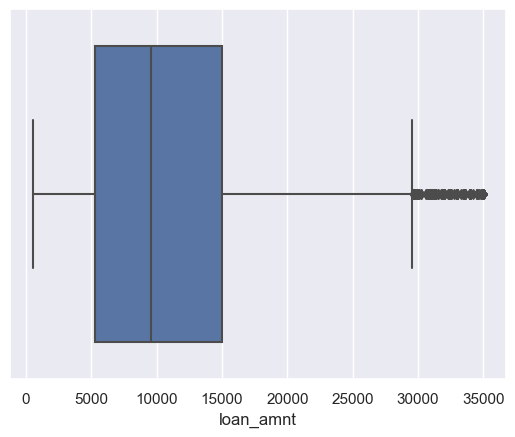

In [178]:
# Plotting Spread of Loan Amount
sns.boxplot(x=loan_df.loan_amnt)

<Axes: xlabel='annual_inc'>

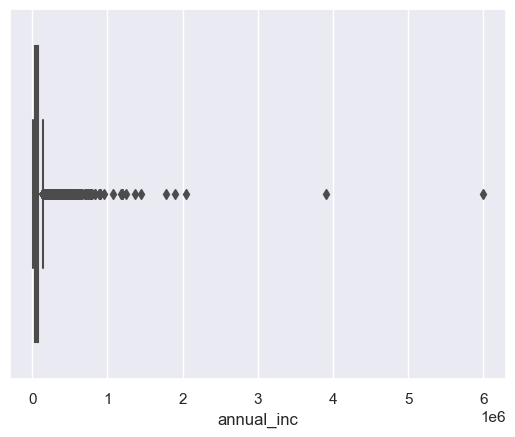

In [179]:
# Plotting Spread of Annual Income
sns.boxplot(x=loan_df.annual_inc)

<Axes: xlabel='dti'>

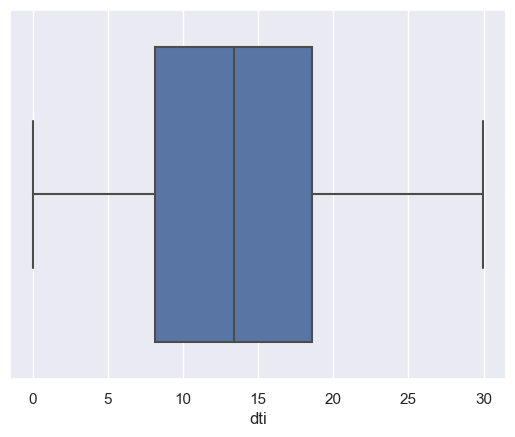

In [180]:
# Plotting Spread of Debt to Income Ratio
sns.boxplot(x=loan_df.dti)

<font color="blue">Removing Outlier for column Annual Income with 99 percentile as there are some outliers beyond this range</font>

In [181]:
loan_df = loan_df[loan_df.annual_inc <= np.percentile(loan_df.annual_inc,99)]

**Conclusion**:  <font color="blue">Data is now cleaned for Analysis and below is the size for the cleaned dataset</font>

In [182]:
# Information about Loan Data Set
get_dataset_info(name_of_dataset="Loan Dataset", df=loan_df, show_details=False)


 Loan Dataset Information: 
-------------------------
Columns: 36 
Rows: 38191


## 1. Univariate Analysis
<span style='background:Gainsboro'>Univariate Analysis  deals with analysing variables one at a time</span><br>
<span style='background:Gainsboro'>Univariate analysis is classified into two types:</span>
- <span style='background:Gainsboro'>**Unordered Univariate Analysis**</span>
- <span style='background:Gainsboro'>**Ordered Univariate Analysis**</span>

## Unordered Univariate Analysis
Analysis is done using single variable and its count. The variable involved does not have and sort of ordering

Text(0, 0.5, 'Count')

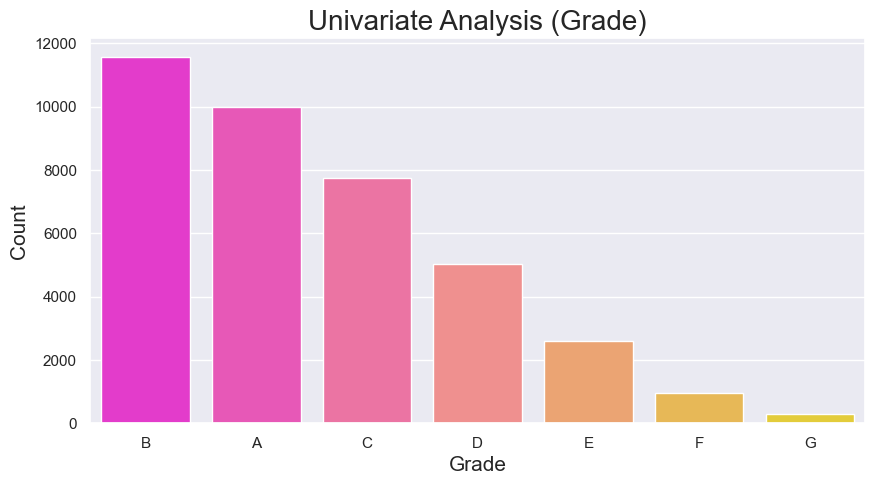

In [205]:
# Plot Countplot graph for grade column to find Univariate Analysis
plt.figure(figsize = (10,5))
sns.countplot(x='grade', data=loan_df, palette='spring', order=loan_df.grade.value_counts().index)
plt.title("Univariate Analysis (Grade)", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: <font color="blue">High number of loans are taken by borrowers with Grade `B` and `A`& Less number of loans are taken by borrowers with Grade `G` and `F`</font>

Text(0, 0.5, 'Count')

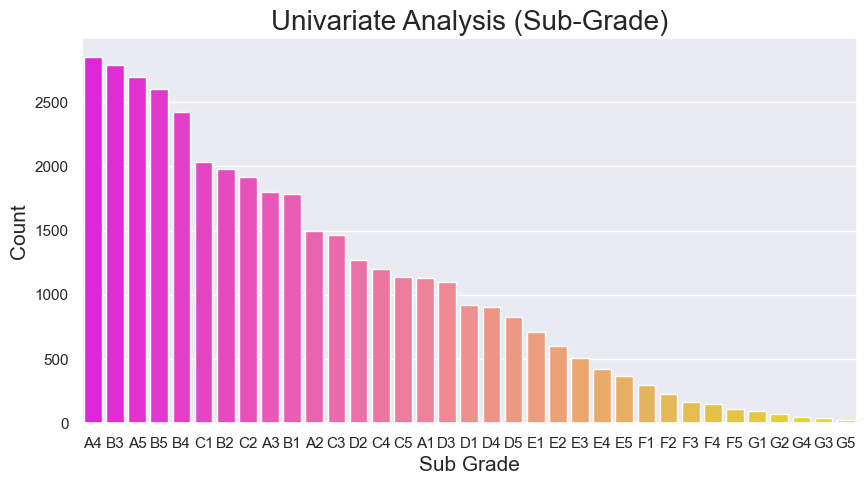

In [206]:
# Plot Countplot graph for sub_grade column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='sub_grade', data=loan_df, order=loan_df.sub_grade.value_counts(ascending=False).index, palette='spring')
plt.title("Univariate Analysis (Sub-Grade)", fontsize=20)
plt.xlabel("Sub Grade", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: <font color="blue">The Loan procuring frequency is falling sequentially from Sub-Grades borrowers from `E1` and above</font>

Text(0, 0.5, 'Count')

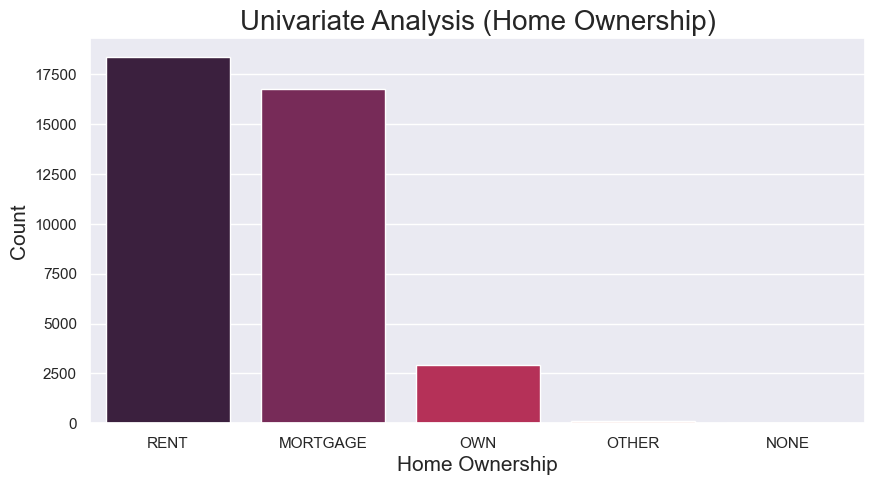

In [207]:
# Plot Countplot graph for home_ownership column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='home_ownership', data=loan_df, order=loan_df.home_ownership.value_counts(ascending=False).index, palette='rocket')
plt.title("Univariate Analysis (Home Ownership)", fontsize=20)
plt.xlabel("Home Ownership", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: <font color="blue">Huge amont of Loans are taken by borrowers who live in `Rented` or `Mortgage` House</font>

Text(0, 0.5, 'Count')

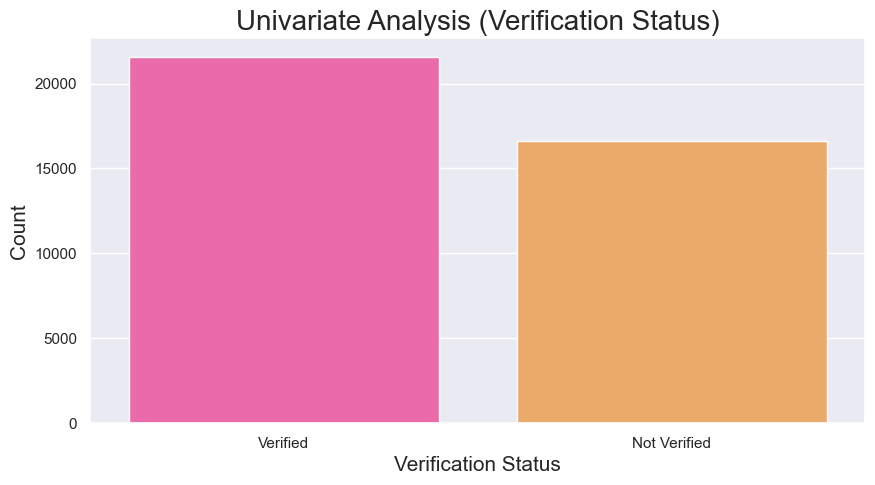

In [208]:
# Plot Countplot graph for verification_status column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='verification_status', data=loan_df, order=loan_df.verification_status.value_counts(ascending=False).index, palette='spring')
plt.title("Univariate Analysis (Verification Status)", fontsize=20)
plt.xlabel("Verification Status", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: <font color="blue">More than `50%` borrowers are verified by the companies.</font>

Text(0, 0.5, 'Count')

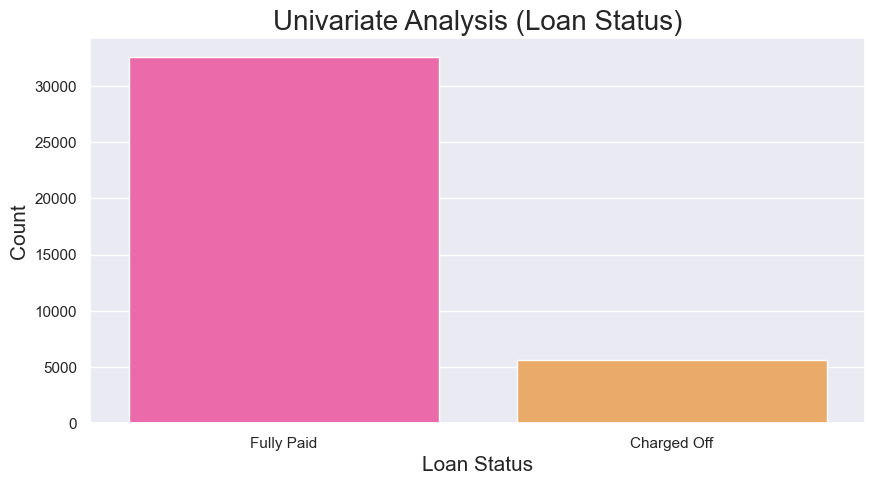

In [209]:
# Plot Countplot graph for loan_status column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='loan_status', data=loan_df, order=loan_df.loan_status.value_counts(ascending=False).index, palette='spring')
plt.title("Univariate Analysis (Loan Status)", fontsize=20)
plt.xlabel("Loan Status", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: <font color="blue">Almost `13%` borrowers have defaulted</font>

Text(0.5, 0, 'Count')

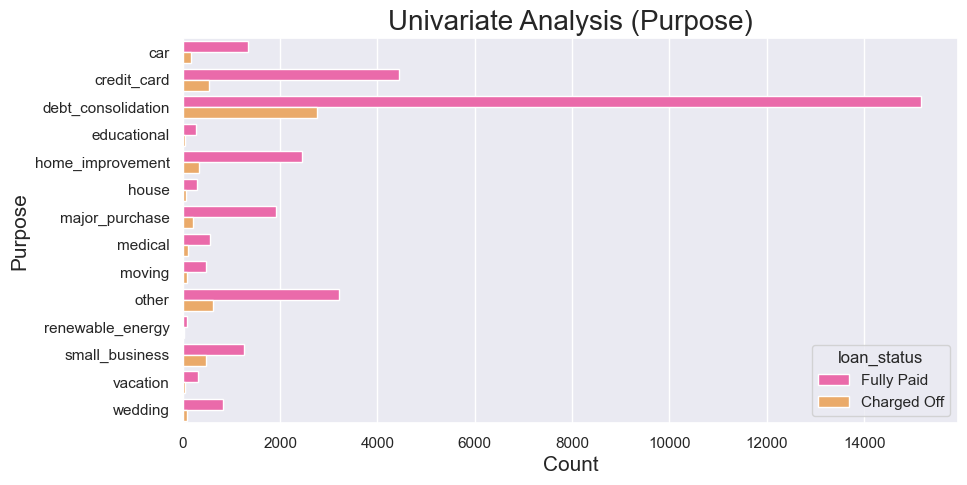

In [210]:
# Plot Countplot graph for purpose column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(y='purpose', data=loan_df, hue=loan_df.loan_status, palette='spring')
plt.title("Univariate Analysis (Purpose)", fontsize=20)
plt.ylabel("Purpose", fontsize=15)
plt.xlabel("Count", fontsize=15)

**Inference**: <font color="blue">Maximum loans are borrowed for the purpose of Debt Consolidation of multiple loans and defaults are also more for same purpose</font>

Text(0, 0.5, 'Count')

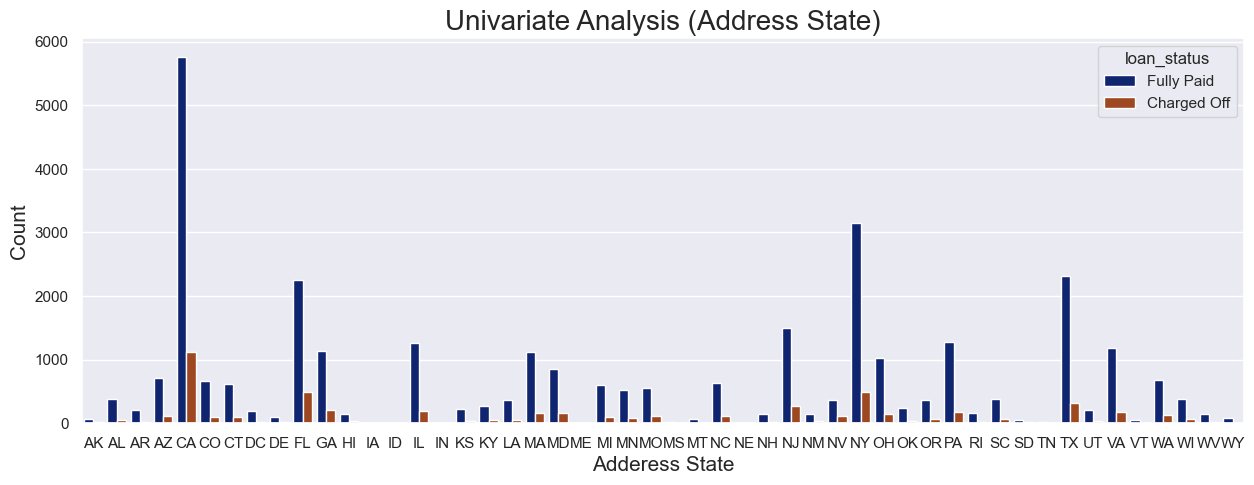

In [211]:
# Plot Countplot graph for addr_state column to find Univariate Analysis
plt.figure(figsize=(15,5))
sns.countplot(x='addr_state', data=loan_df, hue=loan_df.loan_status, palette='dark')
plt.title("Univariate Analysis (Address State)", fontsize=20)
plt.xlabel("Adderess State", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: <font color="blue">Maximum borrowers are from state `California`, `NewYork`, `Texas` and `Florida` and defaulters count is also proportionate</font>

## Ordered Univariate Analysis
Analysis is done using single variable and its count. The variable involved does have some ordering based on date or numerical values

Text(0, 0.5, 'Count')

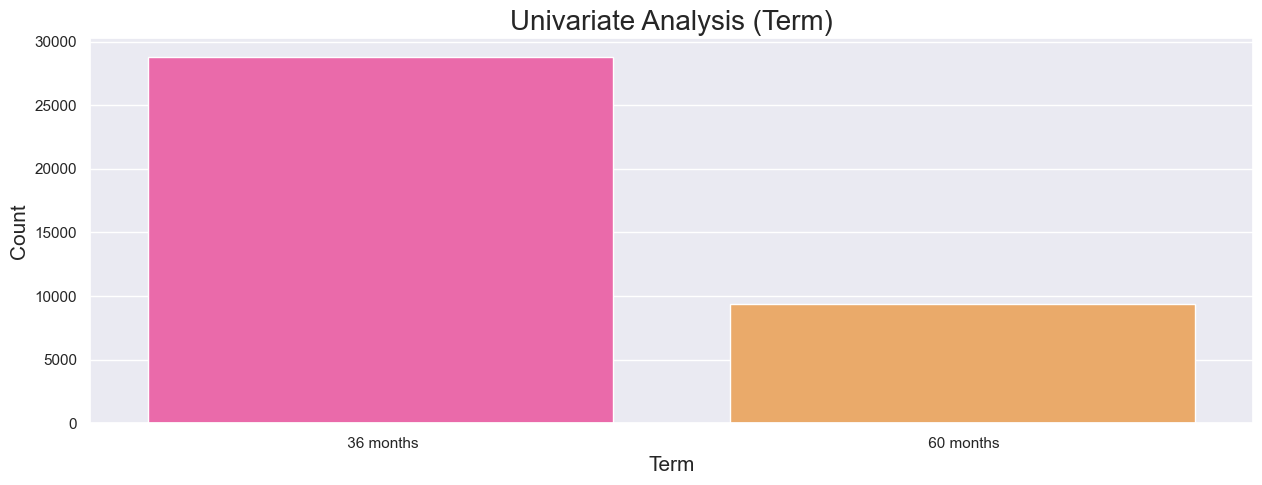

In [212]:
# Plot Countplot graph for term column to find Univariate Analysis
plt.figure(figsize=(15,5))
sns.countplot(x='term', data=loan_df, palette='spring')
plt.title("Univariate Analysis (Term)", fontsize=20)
plt.xlabel("Term", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: <font color="blue">`75%` Loans are borrowed for less duration i.e. `36 Months` than `60 Months` </font>

Text(0, 0.5, 'Count')

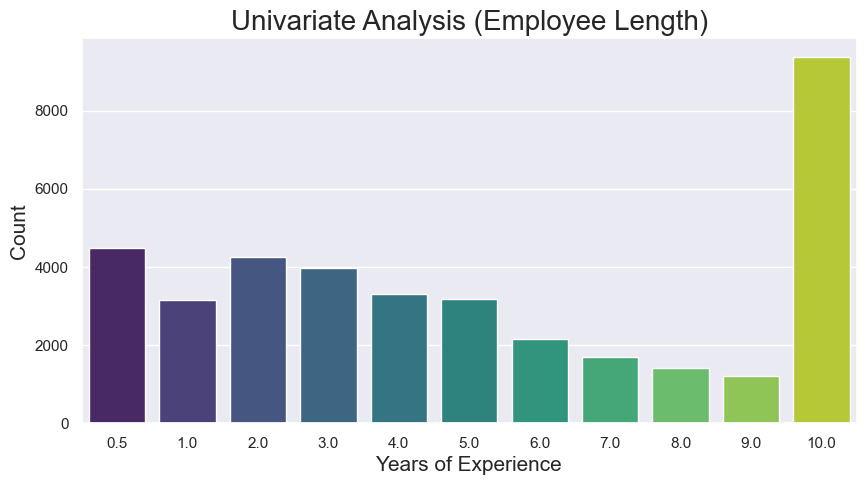

In [213]:
# Plot Countplot graph for interest_rate column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='emp_length', data=loan_df, palette='viridis')
plt.title("Univariate Analysis (Employee Length)", fontsize=20)
plt.xlabel("Years of Experience", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: <font color="blue">Maximum borrowers are having higher experience i.e. greater than equal to 10 years</font>

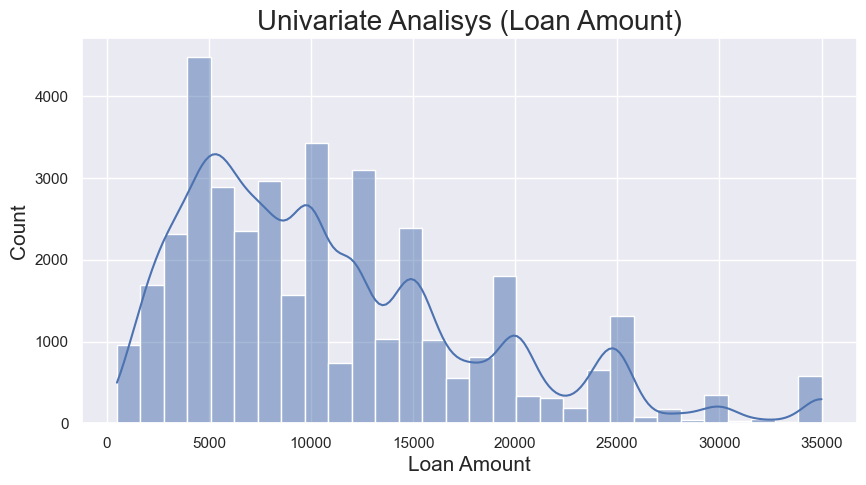

In [220]:
# Histogram plot for distribution of loan_amount
plt.figure(figsize=(10,5))
sns.histplot(loan_df.loan_amnt, kde=True, bins=30)
plt.title('Univariate Analisys (Loan Amount)', fontsize=20)
plt.xlabel('Loan Amount', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

**Inference**: <font color="blue">Maximum loans are borrowed for amount between 5000 to 15000 </font>

Text(0, 0.5, 'Count')

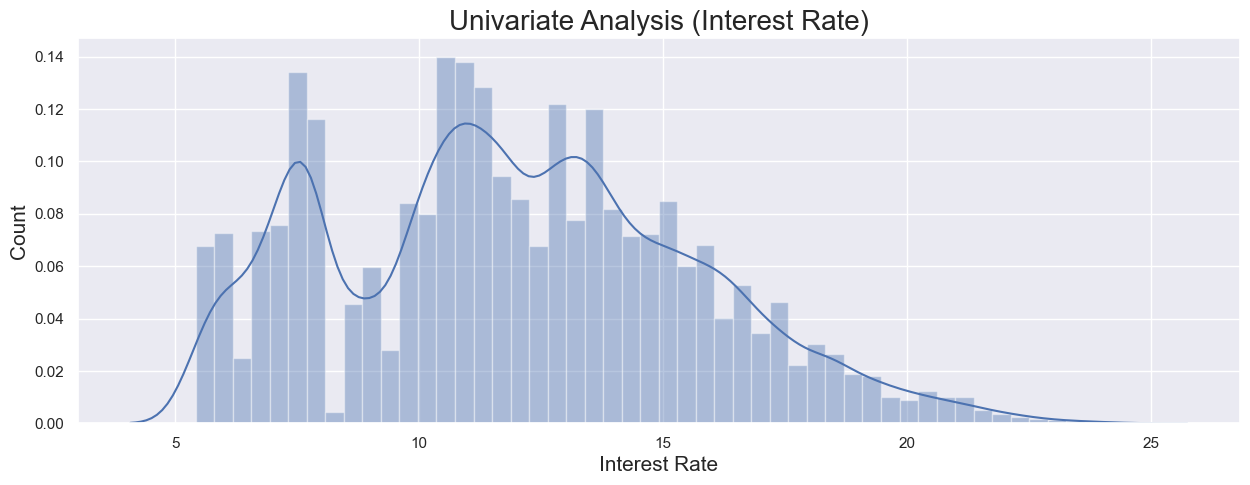

In [221]:
# Plot Countplot graph for interest_rate column to find Univariate Analysis
plt.figure(figsize=(15,5))
sns.distplot(sorted(loan_df.int_rate), kde=True)
plt.title("Univariate Analysis (Interest Rate)", fontsize=20)
plt.xlabel("Interest Rate", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: 
- <font color="blue">More Loans are borrowed by interest rates around 5-8% and 10-15%. The quantity of loans borrowed decreases after 15%</font>
- <font color="blue">no loan is borrowed below 6% and more than 23%</font>

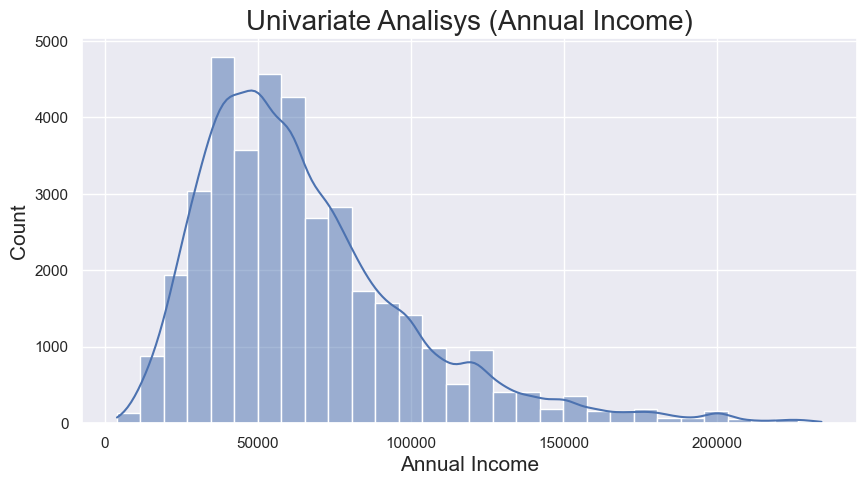

In [222]:
# Histogram plot for distribution of annual_inc
plt.figure(figsize=(10,5))
sns.histplot(loan_df.annual_inc, kde=True, bins=30)
plt.title('Univariate Analisys (Annual Income)', fontsize=20)
plt.xlabel('Annual Income', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

**Inference**: <font color="blue">Majority loans borrowers have less Annual Income as the histogram show left skewed normal distribution</font>

In [ ]:
loan_df.shape

In [ ]:
loan_df.installment.unique()

In [ ]:
loan_df.dtypes